Idea
----

Can you use an RNN, similar to predicting stock prices, to track the history of a team's success? Going to use win % since its already pretty normalized. This should also be applied to teams that have been around a while

In [1]:
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('celticsseason.csv')

stuff to still consider
----------------------

need to reverse list order


is this data shuffled? 

In [3]:
newdf = df['W/L%']

In [4]:
newdf = newdf.dropna()

In [7]:
newdf = newdf.iloc[::-1]


In [10]:
data = newdf.values

In [11]:
def load_data(data, seq_len):
    """Input is an array of all the closing day prices of a given stock, Will arrange it into a sequence of a given length
    In order to make an RNN of that length where output is the change in stock after that day.
    
    Stacks closing prices, and repeats starting one day further down. 
    
    Parameters
    ----------
    
    data : array
        List of closing price values
        
    seq_len : int
        Total # of days to be included per sequence
        

    Returns 
    -------
    
    training and testing data. 
    
    """
    data = data

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
   # np.random.shuffle(train)  #randomizes so while it gets open and close, not doing just daily order 
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]


In [12]:
X_train,y_train,X_test, y_test = load_data(data,5)

In [13]:
#Build Model, based on Siraj IDL 7
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,   
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM( 
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`


compilation time :  0.030476093292236328


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [14]:
np.shape(X_train)

(59, 5, 1)

In [15]:

model.fit(X_train,y_train,batch_size=5 ,nb_epoch=10,validation_split=0.05)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 56 samples, validate on 3 samples
Epoch 1/10
56/56 [==============================] - 2s 39ms/step - loss: 0.1077 - val_loss: 0.0825
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0533
Epoch 3/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1144
Epoch 4/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0093
Epoch 5/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0436
Epoch 6/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0192 - val_loss: 0.1004
Epoch 7/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.1421
Epoch 8/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0656
Epoch 9/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0820
Epoch 10/10
56/56 [==============================] - 0s 2ms/step - loss: 0

In [21]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
from numpy import newaxis

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

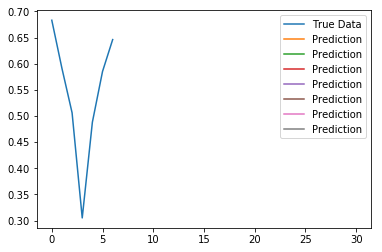

In [25]:
%matplotlib inline
predictions = predict_sequences_multiple(model, X_test, 1, )
plot_results_multiple(predictions, y_test, 1)

In [ ]:
max(X_test)

In [ ]:
newdf = newdf.dropna()

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,0], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,0],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,0], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,0], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,0], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,0], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');